In [60]:
import pandas as pd
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_labels = tf.argmax(y_pred, axis=1)
        self.precision.update_state(y_true, y_pred_labels, sample_weight)
        self.recall.update_state(y_true, y_pred_labels, sample_weight)
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [62]:
model = load_model('bidirectional_lstm/bidirectional_lstm_model.h5', 
                   custom_objects={'F1Score': F1Score})

In [63]:
with open('bidirectional_lstm/word_index.json', 'r') as file:
    word_index = json.load(file)

In [64]:
tokenizer = Tokenizer()
tokenizer.word_index = word_index

In [65]:
data1 = pd.read_csv('datalabel/mbglabel.csv')
data2 = pd.read_csv('datalabel/mbg2label.csv')

In [66]:
datagabung = pd.concat([data1, data2], ignore_index=True)

In [67]:
datagabung.isna().sum()

steming_data    2
Sentiment       0
dtype: int64

In [68]:
datagabung.dropna(subset=['steming_data'], inplace=True)

In [69]:
datagabung.isna().sum()

steming_data    0
Sentiment       0
dtype: int64

In [70]:
datagabung.to_csv("datambg.csv", index=False)

In [71]:
data = pd.read_csv('datambg.csv')

In [72]:
X_test = data['steming_data'].astype(str)
y_test_text = data['Sentiment']

In [73]:
category_to_number = {'Positif': 0, 'Negatif': 1, 'Netral': 2}
y_test_numbered = y_test_text.map(category_to_number)

In [74]:
max_length = data['steming_data'].apply(len).max()
max_length

1174

In [75]:
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [76]:
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad

array([[   1,    3,    2, ...,    0,    0,    0],
       [ 290,    9, 2113, ...,    0,    0,    0],
       [  19, 7744, 7745, ...,    0,    0,    0],
       ...,
       [ 167,    9,   40, ...,    0,    0,    0],
       [ 347,    9, 9573, ...,    0,    0,    0],
       [   9,   10,    0, ...,    0,    0,    0]])

In [77]:
y_pred_proba = model.predict(X_test_pad)
y_pred_proba

326/326 ━━━━━━━━━━━━━━━━━━━━ 30s 92ms/step


array([[9.4523191e-01, 1.9855742e-04, 5.4569524e-02],
       [9.9061406e-01, 1.2710003e-05, 9.3731862e-03],
       [9.9775946e-01, 1.2201532e-06, 2.2393018e-03],
       ...,
       [9.9142820e-01, 9.8133787e-06, 8.5620265e-03],
       [6.8120807e-02, 6.6393726e-02, 8.6548549e-01],
       [1.2102979e-01, 4.4854715e-02, 8.3411551e-01]], dtype=float32)

In [78]:
y_pred_classes = np.argmax(y_pred_proba, axis=1)

In [79]:
class_names = ['Positif', 'Negatif', 'Netral']
labels_ordered = [0, 1, 2]

In [80]:
print(classification_report(y_test_numbered, y_pred_classes, target_names=class_names, labels=labels_ordered))

              precision    recall  f1-score   support

     Positif       0.98      0.96      0.97      7048
     Negatif       0.97      0.91      0.94      1665
      Netral       0.80      0.91      0.85      1694

    accuracy                           0.94     10407
   macro avg       0.92      0.93      0.92     10407
weighted avg       0.95      0.94      0.95     10407



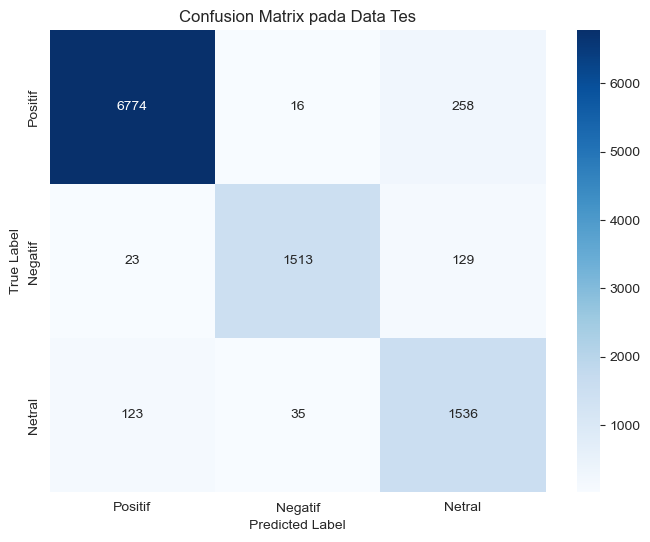

In [81]:
conf_matrix = confusion_matrix(y_test_numbered, y_pred_classes, labels=labels_ordered)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix pada Data Tes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

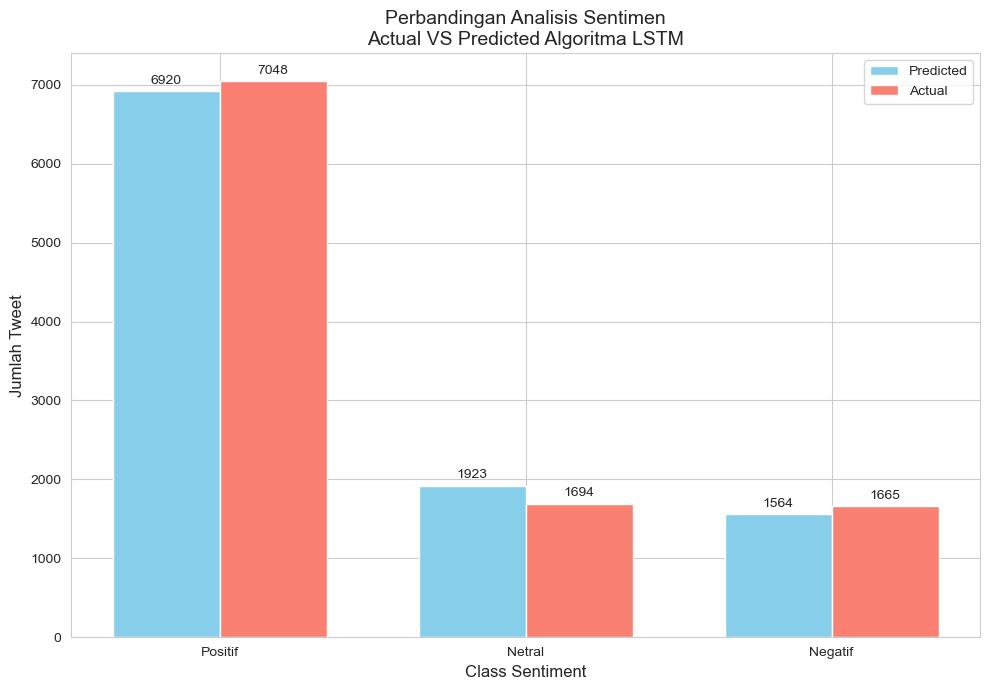

In [82]:
index_to_category = {0: 'Positif', 1: 'Negatif', 2: 'Netral'}
# Ubah prediksi (angka) dan label asli (angka) menjadi teks
y_pred_text = np.array([index_to_category[pred] for pred in y_pred_classes])
y_true_text = y_test_numbered.map(index_to_category)

# Buat DataFrame yang memiliki kolom 'Actual' dan 'Predicted'
results_df = pd.DataFrame({
    'Actual': y_true_text,
    'Predicted': y_pred_text
})

actual_counts = results_df['Actual'].value_counts()
predicted_counts = results_df['Predicted'].value_counts()

plot_df = pd.DataFrame({
    'Actual': actual_counts,
    'Predicted': predicted_counts
}).fillna(0).astype(int)

# BUat plot
sns.set_style("whitegrid")
labels = plot_df.index.tolist()
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - width/2, plot_df['Predicted'], width, label='Predicted', color='skyblue')
rects2 = ax.bar(x + width/2, plot_df['Actual'], width, label='Actual', color='salmon')

ax.set_ylabel('Jumlah Tweet', fontsize=12)
ax.set_xlabel('Class Sentiment', fontsize=12)
ax.set_title('Perbandingan Analisis Sentimen\nActual VS Predicted Algoritma LSTM', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()